# Proyecto Sprint 10: Aprendizaje Supervisado



Los clientes de Beta Bank se están yendo, cada mes, poco a poco. Los banqueros descubrieron que es más barato salvar a los clientes existentes que atraer nuevos. Se necesita predecir si un cliente dejará el banco pronto. 

Se tienen los datos sobre el comportamiento pasado de los clientes y la terminación de contratos con el banco.

Se busca crear un modelo con el máximo valor F1 posible y compararlo con la métrica AUC-ROC.

## Preparación de los datos

In [1]:
# importar todas las librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle


<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor</b> <a class="tocSkip"></a>

Perfecto, buen trabajo importando las librerías necesarias para el desarrollo del proyecto. </div>

In [2]:
# leer los datos y convertir a dataframe
df = pd.read_csv('/datasets/Churn.csv')

df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor</b> <a class="tocSkip"></a>

Perfecto, buen trabajo cargando el dataset necesario para el desarrollo del proyecto.  </div>

A primera vista, se observa que las columnas 'RowNumber', 'CustomerId', y 'Surname' son irrelevantes para incluir en el modelo y, en realidad, dejarlas afectaría el entrenamiento del modelo.


In [3]:
# Eliminar las columnas 'RowNumber', 'CustomerId' y 'Surname'
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           9091 non-null   float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [4]:
# renombrar las columnas
df.columns = df.columns.str.lower()
df = df.rename(columns={'creditscore': 'credit_score', 'numofproducts': 'num_of_products', 'hascrcard' : 'has_cr_card', 'isactivemember' : 'is_active_member', 'estimatedsalary' : 'estimated_salary'})
#print(df.columns)

In [5]:
#revisar valores nulos en la columna 'tenure'
print(df[df['tenure'].isnull()])

      credit_score geography  gender  age  tenure    balance  num_of_products  \
30             591     Spain  Female   39     NaN       0.00                3   
48             550   Germany    Male   38     NaN  103391.38                1   
51             585   Germany    Male   36     NaN  146050.97                2   
53             655   Germany    Male   41     NaN  125561.97                1   
60             742   Germany    Male   35     NaN  136857.00                1   
...            ...       ...     ...  ...     ...        ...              ...   
9944           744   Germany    Male   41     NaN  190409.34                2   
9956           520    France  Female   46     NaN   85216.61                1   
9964           479    France    Male   34     NaN  117593.48                2   
9985           659    France    Male   36     NaN  123841.49                2   
9999           792    France  Female   28     NaN  130142.79                1   

      has_cr_card  is_activ

In [6]:
#rellenar los valores nulos con la media
df['tenure'] = df['tenure'].fillna(df['tenure'].mean())

Se rellenaron los valores nulos de la columna 'tenure', que representaban el 9% de la misma.

Se tiene que todas las columnas son numéricas, excepto 2: 'geography' y 'gender'.

In [7]:
#revisar los valores de las columnas 'geography' y 'gender'

print(df['geography'].unique())
print(df['gender'].unique())

['France' 'Spain' 'Germany']
['Female' 'Male']


La columna 'geography' sólo tiene tres valores distintos y 'gender' dos, por lo que no se consideran variables de alta cardinalidad y el enfoque One-Hot Encoding servirá muy bien para esta tarea, ya sea que se entrene un árbol de decisión, bosque aleatorio o una regresión logística.

In [8]:
# programa nuevo dataframe con One-Hot, con el argumento drop_first=True para evitar la alta correlación en los datos. 
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Se han convertido las variables nominales en booleanas, y el siguiente paso es estandarizar la escala de las variables numéricas.

Para ello, se prepararán previamente todos los datos, obteniendo los conjuntos de entrenamiento y validación.

In [9]:
# separar los datos en target y features
target = df_ohe['exited']
features = df_ohe.drop('exited', axis=1)

# dividir los conjuntos de entrenamiento (75%) y validación (25%)
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

# define las variables numéricas
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

#crea instancia de scaler
scaler = StandardScaler()

# escalar las variables numéricas usando transform()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

print(features_train.shape)
print(features_valid.shape)
print(target_train.shape)
print(target_valid.shape)



(7500, 11)
(2500, 11)
(7500,)
(2500,)


/tmp/ipykernel_349/4201111925.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/envs/python3/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_349/4201111925.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

## Entrenamiento del modelo (parte 1)
Se entrenarán diferentes modelos sin tener en cuenta el desequilibrio de clases.

### Árbol de decisión

In [10]:
# entrenamiento de árbol de decisión
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)


precision = precision_score(target_valid, predicted_valid)
recall = recall_score(target_valid, predicted_valid)
f1 = f1_score(target_valid, predicted_valid)


print('Recall:', recall)
print('Precisión:', precision)
print('Puntuación F1', f1)


Recall: 0.491588785046729
Precisión: 0.4781818181818182
Puntuación F1 0.48479262672811063


La métrica de recall indica que el modelo ha identificado correctamente 49% de las respuestas positivas de entre todas las que tienen una etiqueta positiva.
La métrica de precisión indica que el modelo obtuvo correctamente un 47% de sus predicciones positivas.
El valor F1 combina las dos anteriores, obteniendo una puntuación de 0.48.

Por lo anterior, el modelo es mejor para encontrar verdaderos positivos, pero no lo suficientemente bueno.

### Regresión Logística

In [11]:
# entrenamiento de regresión logística
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print('Recall:', recall_score(target_valid, predicted_valid))
print('Precision:', precision_score(target_valid, predicted_valid))
print('F1:', f1_score(target_valid, predicted_valid))


Recall: 0.19813084112149532
Precision: 0.5760869565217391
F1: 0.2948539638386648


Este modelo no es mejor para encontrar verdaderos positivos (métrica de recall) pero predice correctamente una mayor cantidad de positivos (predice menos falsos positivos con lo que incrementa la precisión). Por lo anterior, la puntuación F1 no mejora.

### Bosque Aleatorio

In [12]:
# entrenamiento de bosque aleatorio

best_score = 0
best_est = 0
best_depth = 0
for est in range(10, 41): # selección del rango del hiperparámetro
    for depth in range (1, 11):
        model = RandomForestClassifier(random_state=54321, n_estimators=est, max_depth = depth) # configura el número y profundidad de árboles
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)   

        if f1 > best_score:
                best_score = f1 # guarda la mejor puntuación de accuracy en el conjunto de validación
                recall_best_score = recall_score(target_valid, predicted_valid)
                precision_best_score = precision_score(target_valid, predicted_valid)
                best_est = est # guarda el número de estimadores que corresponden a la mejor puntuación de exactitud
                best_depth = depth

print("Puntuación del modelo con (n_estimators = {} y max_depth = {}): ".format(best_est, best_depth))
print('Recall:', recall_best_score)
print('Precision:', precision_best_score)
print('F1:', best_score)

Puntuación del modelo con (n_estimators = 24 y max_depth = 9): 
Recall: 0.4280373831775701
Precision: 0.8120567375886525
F1: 0.5605875152998776


Se encontró que un árbol de decisión con 24 árboles y profundidad de 9 obtiene una puntuación f1 de 0.56, aunque no es muy bueno encontrando verdaderos positivos y la puntuación final sigue siendo insuficiente.

## Equilibrio de clases

### Class_weight

El primer enfoque a probar para mejorar el equilibrio de clases es con la regresión logística, ponderando igualmente las clases con el argumento class_weight='balanced'.

In [13]:
model = LogisticRegression(random_state=12345, class_weight='balanced', solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print('Recall:', recall_score(target_valid, predicted_valid))
print('Precision:', precision_score(target_valid, predicted_valid))
print('F1:', f1_score(target_valid, predicted_valid))

Recall: 0.7046728971962617
Precision: 0.3935281837160752
F1: 0.5050234427327529


Este modelo es significativamente mejor para encontrar verdaderos positivos (métrica de recall) pero predice incorrectamente una gran cantidad de positivos (predice muchos falsos positivos, al rededor del 61%). La puntuación F1 mejora en contraste con el mismo modelo sin equilibrio de clases, pero no es el mejor.

### Sobremuestreo

In [14]:
# investiga la occurrencia de clases
print(target_train[target_train==1].count())
print(target_train[target_train==0].count())

1502
5998


Las clases negativas representan aproximadamente el 80% de las ocurrencias.

Después, se probarán los métodos de sobremuestreo y submuestreo.

Para el sobremuestreo, se duplicarán las ocurrencias positivas de manera que representen un 33% de las ocurrencias, en lugar de 20% sin sobremuestreo.

In [15]:
features_zeros = features_train[target_train == 0]
features_ones = features_train[target_train == 1]
target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]

features_train_upsampled = pd.concat([features_zeros] + [features_ones] * 2)
target_train_upsampled = pd.concat([target_zeros] + [target_ones] * 2)


# mezcla los datos
features_upsampled, target_upsampled = shuffle(features_train_upsampled, target_train_upsampled, random_state=12345)

print(target_upsampled[target_upsampled==1].count())
print(target_upsampled[target_upsampled==0].count())

print(features_upsampled.shape)
print(target_upsampled.shape)

3004
5998
(9002, 11)
(9002,)


#### Regresión logística

In [16]:
# entrena modelo de regresión logística con los datos con sobremuestra
model = LogisticRegression(random_state = 12345, solver = 'liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print('F1 sobremuestreo sin balance de clase:', f1_score(target_valid, predicted_valid))

model = LogisticRegression(random_state = 12345, class_weight='balanced', solver = 'liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print('F1 sobremuestreo con balance de clase:', f1_score(target_valid, predicted_valid))


F1 sobremuestreo sin balance de clase: 0.46138807429130013
F1 sobremuestreo con balance de clase: 0.5050234427327529


El score F1 mejoró en contraste con el primer modelo de regresión logística que se entrenó, sin balanceo de clases, pero no lo hizo en comparación con el modelo de regresión logística con balance de clase.

#### Árbol de decisión

In [17]:
# entrena árbol de decisión con los datos con sobremuestra

model = DecisionTreeClassifier(random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print('F1 :', f1_score(target_valid, predicted_valid))

F1 : 0.48314606741573035


El árbol de decisión con sobremuestreo tampoco demuestra mejoría.

#### Bosque aleatorio

In [18]:
# entrenamiento de bosque aleatorio con los datos con sobremuestra, y el número de estimadores y profundidad encontrados previamente.

model = RandomForestClassifier(random_state=54321, n_estimators=24, max_depth = 9) 
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print('F1 :', f1_score(target_valid, predicted_valid))

F1 : 0.6286919831223629


In [19]:
# entrena otro bosque aleatorio que encuentre un valor f1 óptimo dentro de los rangos de los hiperparámetros
best_score = 0
best_est = 0
best_depth = 0
for est in range(10, 41): # selección del rango del hiperparámetro
    for depth in range (1, 11):
        model = RandomForestClassifier(random_state=54321, n_estimators=est, max_depth = depth) # configura el número y profundidad de árboles
        model.fit(features_upsampled, target_upsampled)
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)   

        if f1 > best_score:
                best_score = f1 # guarda la mejor puntuación de accuracy en el conjunto de validación
                best_est = est # guarda el número de estimadores que corresponden a la mejor puntuación de exactitud
                best_depth = depth

print("Puntuación del modelo con (n_estimators = {} y max_depth = {}): ".format(best_est, best_depth))
print('F1:', best_score)

Puntuación del modelo con (n_estimators = 21 y max_depth = 9): 
F1: 0.6337880377754459


El bosque aleatorio con los datos con sobremuestra tiene una mejoría aceptable.

### Submuestreo

Para el submuestreo, la última técnica de equilibrio de clases a probar, se reducirá la frecuencia de la clase predominante (0) en un 35%, es decir, quedará un 65% de los datos de la clase negativa.

In [36]:
# obtén features y target eliminando 35% de las ocurrencias negativas.
features_downsampled = pd.concat([features_zeros.sample(frac = 0.65, random_state=12345)] + [features_ones])
target_downsampled = pd.concat([target_zeros.sample(frac = 0.65, random_state=12345)] + [target_ones])

# mezcla los datos
features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state = 12345)

print(target_downsampled[target_downsampled==1].count())
print(target_downsampled[target_downsampled==0].count())

print(features_downsampled.shape)
print(target_downsampled.shape)


1196
3123
(4319, 11)
(4319,)


#### Regresión logística

In [21]:
# entrena modelo regresión logística con los nuevos datos

model = LogisticRegression(random_state = 12345, solver = 'liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print('F1 con submuestra de datos:', f1_score(target_valid, predicted_valid))


model = LogisticRegression(random_state = 12345, class_weight='balanced', solver = 'liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print('F1 con submuestra de datos y balanceo de clase:', f1_score(target_valid, predicted_valid))

F1 con submuestra de datos: 0.41269841269841273
F1 con submuestra de datos y balanceo de clase: 0.505685618729097


La regresión logística continua sin dar resultados notablemente mejorados.

#### Árbol de decisión

In [22]:
# entrena árbol de decisión con los datos con submuestra

model = DecisionTreeClassifier(random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print('F1 :', f1_score(target_valid, predicted_valid))

F1 : 0.51067463706234


#### Bosque aleatorio

In [23]:
# entrenamiento de bosque aleatorio

model = RandomForestClassifier(random_state=54321, n_estimators=24, max_depth = 9) 
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print('F1 :', f1_score(target_valid, predicted_valid))

F1 : 0.6019845644983463


In [24]:
# entrena otro bosque aleatorio
best_score = 0
best_est = 0
best_depth = 0
for est in range(10, 41): # selección del rango del hiperparámetro
    for depth in range (1, 11):
        model = RandomForestClassifier(random_state=54321, n_estimators=est, max_depth = depth) # configura el número y profundidad de árboles
        model.fit(features_downsampled, target_downsampled)
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)   

        if f1 > best_score:
                best_score = f1 # guarda la mejor puntuación de accuracy en el conjunto de validación
                best_est = est # guarda el número de estimadores que corresponden a la mejor puntuación de exactitud
                best_depth = depth

print("Puntuación del modelo con (n_estimators = {} y max_depth = {}): ".format(best_est, best_depth))
print('F1:', best_score)

Puntuación del modelo con (n_estimators = 21 y max_depth = 8): 
F1: 0.6114221724524076


El submuestreo en el bosque aleatorio también mejoró el modelo, pero no tanto como el sobremuestreo.

## Prueba final

Para la prueba final, se divide finalmente el dataset en conjuntos de entrenamiento (60%), validación (20%) y prueba (20%), para testar el mejor modelo: el bosque aleatorio aplicando la técnica de sobremuestreo.

In [25]:
# dividir el dataset en conjunto de entrenamiento y resto
df_train, df_test_and_validation = train_test_split(df_ohe, test_size=0.40, random_state=12345) # separa los datos en entrenamiento y resto
df_test, df_validation = train_test_split(df_test_and_validation, test_size=0.50, random_state=12345) # separa los datos restantes en prueba y validación

# declara variables para las características y para la característica objetivo

features_train = df_train.drop(['exited'], axis=1)
target_train = df_train['exited']

features_validation = df_validation.drop(['exited'], axis=1)
target_validation = df_validation['exited']

features_test = df_test.drop(['exited'], axis=1)
target_test = df_test['exited']



In [26]:

# escalar las variables numéricas usando transform()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(features_train.shape)
print(target_train.shape)
print(features_validation.shape)
print(target_validation.shape)
print(features_test.shape)
print(target_test.shape)


(6000, 11)
(6000,)
(2000, 11)
(2000,)
(2000, 11)
(2000,)


/tmp/ipykernel_349/3222388798.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_valid[numeric] = scaler.transform(features_valid[numeric])
/opt/conda/envs/python3/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [27]:
# investiga la occurrencia de clases
print(target_train[target_train==1].count())
print(target_train[target_train==0].count())

1196
4804


In [28]:
# realiza el sobremuestreo
features_zeros = features_train[target_train == 0]
features_ones = features_train[target_train == 1]
target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]

features_train_upsampled = pd.concat([features_zeros] + [features_ones] * 2)
target_train_upsampled = pd.concat([target_zeros] + [target_ones] * 2)

# mezcla los datos
features_upsampled, target_upsampled = shuffle(features_train_upsampled, target_train_upsampled, random_state=12345)

print(target_upsampled[target_upsampled==1].count())
print(target_upsampled[target_upsampled==0].count())

print(features_upsampled.shape)
print(target_upsampled.shape)

2392
4804
(7196, 11)
(7196,)


In [29]:
# entrenamiento del bosque aleatorio para aplicar al conjunto de prueba
best_score = 0
best_est = 0
best_depth = 0
for est in range(10, 41): # selección del rango del hiperparámetro
    for depth in range (1, 11):
        model = RandomForestClassifier(random_state=54321, n_estimators=est, max_depth = depth) # configura el número y profundidad de árboles
        model.fit(features_upsampled, target_upsampled)
        predicted_test = model.predict(features_test)
        f1 = f1_score(target_test, predicted_test)   

        if f1 > best_score:
                best_score = f1 # guarda la mejor puntuación de accuracy en el conjunto de validación
                best_est = est # guarda el número de estimadores que corresponden a la mejor puntuación de exactitud
                best_depth = depth

print("Puntuación del modelo final con (n_estimators = {} y max_depth = {}): ".format(best_est, best_depth))
print('F1:', best_score)

Puntuación del modelo final con (n_estimators = 36 y max_depth = 8): 
F1: 0.6298788694481829


El modelo de la prueba final tiene una puntuación de 0.629. Para ver si esta puntuación puede mejorar, se ajustará el umbral en 10 puntos porcentuales.

In [33]:
# recrea el modelo anterior con los hiperparámetros obtenidos.

model = RandomForestClassifier(random_state=54321, n_estimators = 36, max_depth = 8)
model.fit(features_upsampled, target_upsampled)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

# Ajuste de umbral
threshold = 0.40
predicted_test = probabilities_one_test > threshold

print('F1 score: ',f1_score(target_test, predicted_test))



F1 score:  0.6307339449541286


## Curva AUC-ROC
La métrica AUC-ROC, a diferencia del valor F1, considera métricas que no implican dividir entre cero: la tasa de verdaderos positivos y la tasa de falsos positivos.

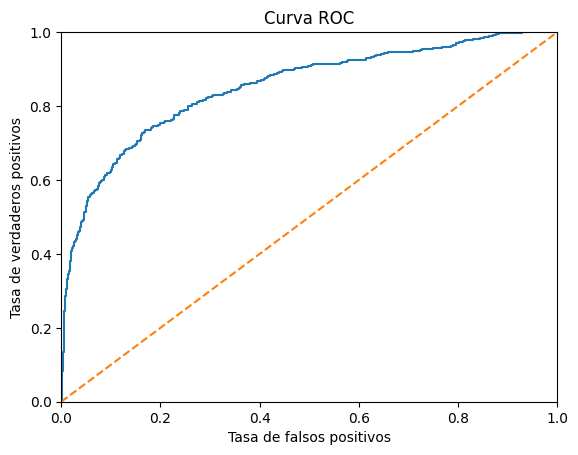

In [34]:
# encuentra la curva roc

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()

# traza la gráfica
plt.plot(fpr, tpr)
# Curva ROC para modelo aleatorio
plt.plot([0, 1], [0, 1], linestyle='--')

# establecer el límite para los ejes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# nombra los ejes y el título
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()



In [35]:
# calcula el valor AUC-ROC
auc_roc = roc_auc_score(target_test, probabilities_one_test)

print(auc_roc)


0.8504406632026568


El valor del área bajo la curva ROC sugiere que hay un 85% de probabilidades de que el modelo clasificará de manera correcta una ocurrencia positiva elegido al azar más alta que una ocurrencia negativa elegida al azar.

## Conclusión

**Resumen de los hallazgos obtenidos:**
    
**Puntuación F1 de los modelos sin tomar en cuenta el desequilibrio de clases:**

Árbol de decisión: 0.484

Regresión logística: 0.294

Bosque aleatorio: 0.56



**Puntuacíón F1 de los modelos aplicando técnicas para corregir el desequilibrio de clases:**

Árbol de decisión: 0.51

Regresión logística: 0.505

Bosque aleatorio: 0.634

**Puntuación F1 del modelo final:**

Sin ajuste de umbral: 0.629

Con ajuste de umbral: 0.63

**Puntuación AUC-ROC del modelo elegido:**

0.85
